<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/autoencoder/latent_units_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# NEW! for doing PCA on the model output
# principal component analysis (PCA) is a statistical technique for analyzing large datasets
# it reduces the dimensionality of a dataset while preserving its most meaningful features

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [38]:
# import dataset (comes with Colab):
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# extract labels, then remove the labels from data:
labels = data[:,0]
data   = data[:,1:]

# normalize the data:
dataNorm = data / np.max(data) # np array

# np array -> torch tensor:
dataT = torch.tensor( dataNorm ).float()
print(dataT.shape)

(20000, 785)
torch.Size([20000, 784])


In [39]:
def createTheMNISTAE():

  # create a class for the model:
  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,150)

      ### encoder layer
      self.enc = nn.Linear(150,15)

      ### latent layer
      self.lat = nn.Linear(15,150)

      ### decoder layer
      self.dec = nn.Linear(150,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      codex = F.relu( self.enc(x) ) # save codex, so it can be returned later and won't be overwritten by x
      x = F.relu( self.lat(codex) )
      y = torch.sigmoid( self.dec(x) ) # get the outputs in the same range as the normalized inputs
      return y,codex

  # create a model instance
  net = aenet() # return y,codex

  # loss function
  lossfun = nn.MSELoss() # MSELoss for regression problem

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer # untrained

In [40]:
# test the model with a bit of data:

net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X) # an untrained network that returns (y,codex)

print('Input shape:')
print(X.shape, "\n")

# yHat is now a tuple that returns (y,codex)
print(type(yHat),len(yHat), "\n")

print('Shape of model output:')
print(yHat[0].shape, "\n")

print('Shape of encoding layer output:')
print(yHat[1].shape)

Input shape:
torch.Size([5, 784]) 

<class 'tuple'> 2 

Shape of model output:
torch.Size([5, 784]) 

Shape of encoding layer output:
torch.Size([5, 15])


In [44]:
# scratch:
print(np.random.choice(10,size=6)) # may have duplicate
print(np.random.permutation(6))

[1 6 5 9 8 1]
[2 4 1 0 5 3]


In [42]:
# create a function to train the model:
def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  numepochs = 10000
  losses = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # randomly select 32 images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass
    yHat = net(X)[0] # tuple (y,codex) -> return y only
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record loss for
    # print(type(loss)) # torch tensor
    # print(loss.item()) # a single value, 0.020131545141339302 for example
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

Final loss: 0.0171


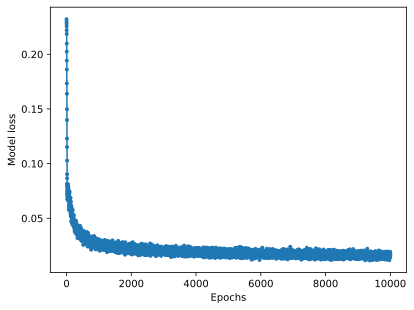

In [43]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-') # plot the losses array as dots with a line connecting them
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Inspect the latent layer of the model:

torch.Size([20000, 784])
torch.Size([20000, 15])


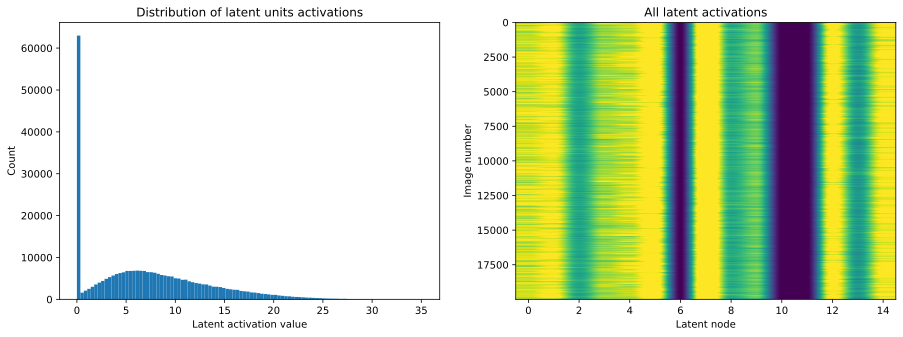

In [45]:
# output the latent layer

# push through the entire dataset
yHat,latent = net(dataT) # tuple (y,codex)

# print sizes
print(yHat.shape)
print(latent.shape)

# what does it look like?
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.flatten().detach(),100)
ax[0].set_xlabel('Latent activation value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of latent units activations')

ax[1].imshow(latent.detach(),aspect='auto',vmin=0,vmax=10)
ax[1].set_xlabel('Latent node')
ax[1].set_ylabel('Image number')
ax[1].set_title('All latent activations')

plt.show()

In [48]:
# scratch:
print(latent.shape)
latent

torch.Size([20000, 15])


tensor([[10.4959, 12.4585, 10.1766,  ..., 13.3440, 15.0041,  3.0265],
        [10.6087,  7.7790,  7.6340,  ...,  3.6527,  5.6334, 11.6135],
        [17.4045,  8.7524,  3.3856,  ...,  9.0983,  1.8487,  4.5189],
        ...,
        [ 9.8358,  9.0438,  3.5618,  ..., 16.4098,  0.0000,  5.5307],
        [ 7.7958,  2.7063,  4.7480,  ..., 16.2934,  2.5803,  3.6549],
        [ 4.6505, 16.9930,  4.7563,  ...,  0.5771,  7.9209,  9.4683]],
       grad_fn=<ReluBackward0>)

<ipython-input-49-cc9c01a8338e>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  sourcecode[:,i] = torch.mean(latent[digidx,:],axis=1).detach()


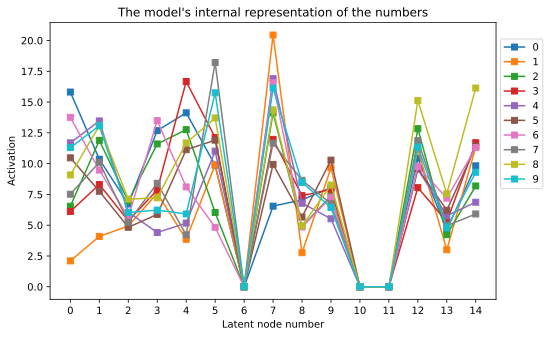

In [49]:
# compute the average latent activation for each digit type (0-9)

# initialize output matrix (latent shape by 10 digits)
sourcecode = np.zeros((latent.shape[1],10))

# loop over digit categories
for i in range(10):

  # find all indices for this type:
  digidx = np.where(labels==i)

  # average the latent layer output
  sourcecode[:,i] = torch.mean(latent[digidx,:],axis=1).detach()

# visualize:
fig = plt.figure(figsize=(8,5))
plt.plot(sourcecode,'s-')
plt.legend(range(10),loc=(1.01,.4))
plt.xticks(range(15))
plt.xlabel('Latent node number')
plt.ylabel('Activation')
plt.title("The model's internal representation of the numbers")
plt.show()

👆 Observations and interpretations:
- Units 3, 10, and 11 are basically never active.
- Technically this is a 15 dimensional space. But in practice, it's really only 12 dimensional, because 3 out of 15 are simply not using.

# Explore the reduced-compressed space with PCA:

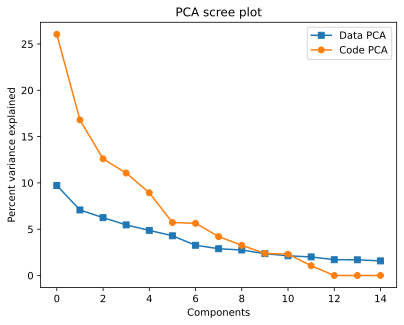

In [51]:
# for comparison:
pcaData = PCA(n_components=15).fit(data) # take the first 15 components of the data space for comparison
pcaCode = PCA(               ).fit(latent.detach()) # the latent space is already 15 dimensional

# plot the eigenspectra (scree plot)
plt.plot(100*pcaData.explained_variance_ratio_,'s-',label='Data PCA')
plt.plot(100*pcaCode.explained_variance_ratio_,'o-',label='Code PCA')
plt.xlabel('Components')
plt.ylabel('Percent variance explained')
plt.title('PCA scree plot')
plt.legend()
plt.show()

👆 Interpretations:
- The last three components for the the "Code PCA" are zero (eigenvalues are zero), demonstrating although we technically have 15 dimensions in practice, it's only an 12 dimensional space.
- The latent space has a more compact, sparser, and more efficient representation of the data compared to the raw data space.

In [52]:
# compute the projection of the data onto the PC axes
scoresData = pcaData.fit_transform(data)
scoresCode = pcaCode.fit_transform(latent.detach())

# plot the data separately per number
fig,ax = plt.subplots(1,2,figsize=(15,5))

for lab in range(10):
  ax[0].plot(scoresData[labels==lab,0],scoresData[labels==lab,1],'o',markersize=3,alpha=.4)
  ax[1].plot(scoresCode[labels==lab,0],scoresCode[labels==lab,1],'o',markersize=3,alpha=.4)

for i in range(2):
  ax[i].set_xlabel('PC1 projection')
  ax[i].set_ylabel('PC2 projection')
  ax[i].legend(range(10))

ax[0].set_title('PCA of data')
ax[1].set_title('PCA of latent code')
plt.show()

# Reduced dimensional space:

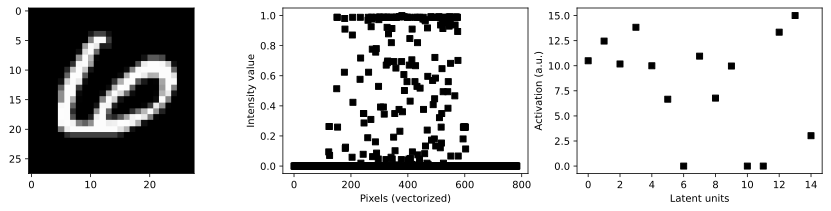

In [53]:
fig,ax = plt.subplots(1,3,figsize=(15,3))

ax[0].imshow(dataT[0,:].view(28,28),cmap='gray')

ax[1].plot(dataT[0,:],'ks')
ax[1].set_xlabel('Pixels (vectorized)')
ax[1].set_ylabel('Intensity value')

ax[2].plot(latent[0,:].detach(),'ks')
ax[2].set_xlabel('Latent units')
ax[2].set_ylabel('Activation (a.u.)')

plt.show()